# Odhady $\lambda_1$ pomocí $u_1'$ a lineární interpolace

### Otázky a TODO

1. při integraci $v_1'$ dělám jednu ze 2 věcí aby všechny hodnoty byly $\geq 0$ :
    - posouvám funkci "nahoru" o nejmenší hodnotu
    - uřežu všechny intervaly které jsou pod nulu  
   Co z toho je správně?
2. V numerickém řešením je $t$ vždy interval $[0,1]$, i když v případě dolního odhadu ho zvětšujeme o $r$ na obě strany
3. V dolním odhadu je pořád někde chyba, je strašně nepřesný

In [21]:
using DrWatson
@quickactivate "Eigenvalue bounds of p-Laplacian"

using Plots; gr()

include(srcdir("pLaplaceNumerics.jl"));
include(srcdir("pLaplaceInterpolation.jl"));
include(srcdir("pLaplaceEstimates.jl"));

In [22]:
#### Nastavení parametrů výpočtu obou odhadů ####

n = 31 # number of division points
ns = 1 # number of subdivision points of each subinterval

λ₁ᵉˣᵃᶜᵗ(P) = (P-1)*(2*(π/P)/(sin(π/P)))^P

p = 2
λ₁ = λ₁ᵉˣᵃᶜᵗ(p)
λᵢₙᵢₜ = (3.,1.5*λ₁);




In [23]:
"""
    integrate_v1d(p, V₁d, t)

Rebuilds interval expression of `V₁` by integrating `V₁d`.

Arguments:
p             ... p of p-Laplacian
V₁d            ... intervals values of V₁d
t             ... division points
"""
function integrate_v1d(p, V₁d, t; dom=(0.0, 1.0))
    
    tl, tr = dom
    ni = mince(tl..tr,length(V₁d))

    V₁_tmp = Interval[0..0]
    for i in 1:length(V₁d)
        append!(V₁_tmp, V₁_tmp[end] + V₁d[i] * diam(ni[i]))
    end
    
    V₁ = Interval[]
    for i in 1:length(V₁_tmp)-1
        append!(V₁, V₁_tmp[i] ∪ V₁_tmp[i+1])
        # oříznutí intervalů které jdou do záporných hodnot
        #if inf(V₁[end]) < 0
        #    V₁[end] = 0 .. sup(V₁[end])
        #end
    end
    
    #"zvednutí" hodnot tak aby nebyla fce záporná
    V₁ = V₁ .- inf(minimum(V₁))
    
    return V₁
end;

### Horní odhad

$$ \lambda_{1,p} \leq \frac{\int_0^1 | v(t)'|^p \text{dt}}{\int_0^1 | v(t)|^p \text{dt}} $$

**Postup**

1. použijeme $u_1'$ a proložíme ji:
    - nejprve lineárně
    - potom lineárně, ale v místě protnutí osy x asi kubicky
2. získáme $u_1$ integrováním
3. horní odhad ze vzorce 


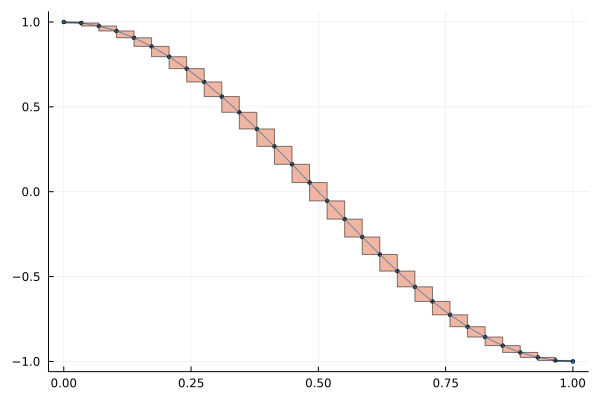

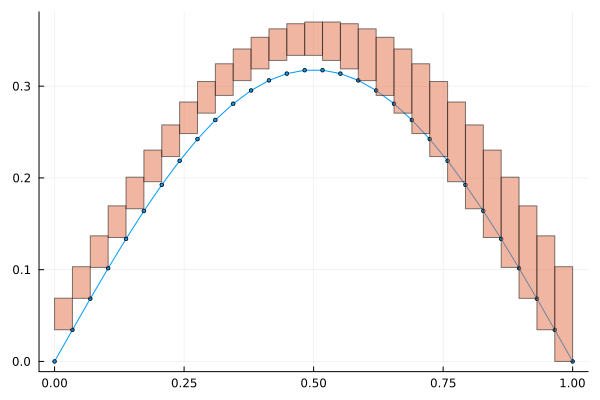

Přesné řešení λ₁: 9.869604401089358
Horní odhad pomocí po částech lineární fce: 9.874579940780771


In [24]:
#### Numerické řešení ####

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, U₁d, U₁dᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n); #, 
    
U₁[end] = 0
U₁ᴵ[end] = 0..0; 

#### Interpolace u₁' po částech lineární funkcí #####
csc_V₁d_lin, V₁d_lin = linear_interpolation(t, U₁dᴵ);

plt = plot(t, U₁d, marker=2)
boxes = IntervalBox.(tᴵ, V₁d_lin)    
plot!(boxes, legend=false)
display(plt)


#### získání v₁ z v₁' pomocí integrace ####
V₁_lin = integrate_v1d(p, V₁d_lin, t)
plt = plot(t, U₁, marker=2)
boxes = IntervalBox.(tᴵ, V₁_lin)    
plot!(boxes, legend=false)
display(plt)

#### horní odhad ####

λ₁ᵘᵖ = upper_estimate(V₁_lin, V₁d_lin, p)
println("Přesné řešení λ₁: $(λ₁ᵉˣᵃᶜᵗ(p))")
println("Horní odhad pomocí po částech lineární fce: $(λ₁ᵘᵖ)")

### Dolní odhad

$$ \lambda_{1,p} \geq \inf_{t \in (0,1)} \frac{-\Delta_p v(t)}{v(t)^{p-1}} $$

**Postup**

1. použijeme $u_1'$ a proložíme ji:
    - nejprve lineárně
    - potom lineárně, ale v místě protnutí osy x asi kubicky
2. získáme $u_1$ integrováním
3. získáme $\Delta_p u_1$ z definice pomocí $u_1'$
4. dolní odhad ze vzorce


In [25]:
function get_v2d(csc, t, p)
    
    V_tmp = Interval[]
    for i in 1:length(t)-1
        x_int = t[i]..t[i+1] 
        if csc[i][3]*(x_int-t[i])+csc[i][4] < 0
            append!(V_tmp, (p-1)*(-(csc[i][3]*(x_int-t[i])+csc[i][4]))^(p-2)*csc[i][3])
        else
            append!(V_tmp, (p-1)*(csc[i][3]*(x_int-t[i])+csc[i][4])^(p-2)*csc[i][3])
        end 
    end
    
    V = Interval[]
    for i in 1:length(V_tmp)-1
        append!(V, V_tmp[i] ∪ V_tmp[i+1])
    end
    append!(V, V_tmp[end])
        
    return V
end;

    

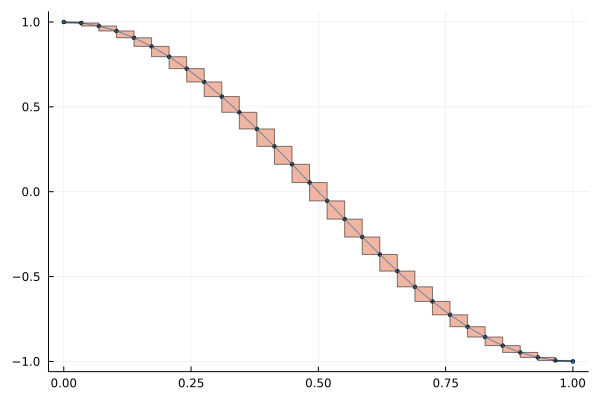

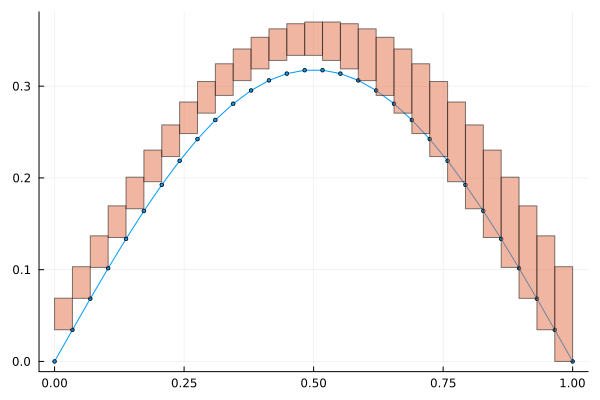

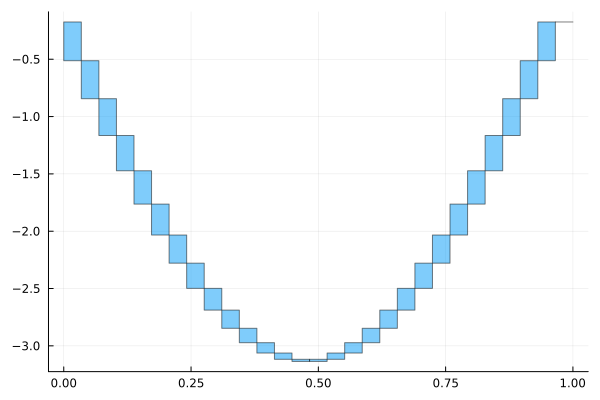

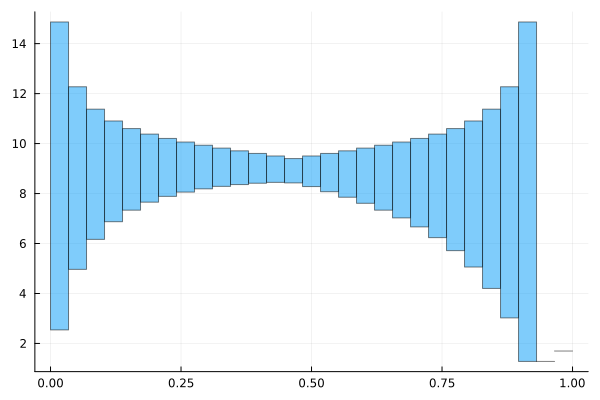

Přesné řešení λ₁: 9.869604401089358
Dolní odhad pomocí po částech lineární fce: 1.2800095211560036


In [26]:
#### Numerické řešení ####

r = 10/(n*ns)
dom = (-r, r+1)

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Ud, Udᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n)#, dom=dom);

#### Interpolace u₁' po částech lineární funkcí #####
csc_V₁d_lin, V₁d_lin = linear_interpolation(t, U₁dᴵ);
plt = plot(t, U₁d, marker=2)
boxes = IntervalBox.(tᴵ, V₁d_lin)    
plot!(boxes, legend=false)
display(plt)


#### získání v₁ z v₁' pomocí integrace ####
V₁_lin = integrate_v1d(p, V₁d_lin, t)#, dom=dom)
plt = plot(t, U₁, marker=2)
boxes = IntervalBox.(tᴵ, V₁_lin)    
plot!(boxes, legend=false)
display(plt)


#### získání Δₚu pomocí u₁' ####
V₂d_lin = get_v2d(csc_V₁d_lin, t, p)
boxes = IntervalBox.(tᴵ, V₂d_lin)    
plt = plot(boxes, legend=false)
display(plt)


#### dolní odhad ####
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(V₂d_lin, V₁_lin, p)
println("Přesné řešení λ₁: $(λ₁ᵉˣᵃᶜᵗ(p))")
println("Dolní odhad pomocí po částech lineární fce: $(λ₁ˡᵒʷ)")
boxes = IntervalBox.(tᴵ, Fˡᵒʷ)    
plt = plot(boxes, legend=false)
display(plt)

